In [1]:
from pyscf import gto, dft, scf, lib, cc, fci
import numpy as np
import scipy as sp

In [41]:
# basis_set = 'cc-pVDZ'
basis_set = 'sto3g'

<IPython.core.display.Javascript object>


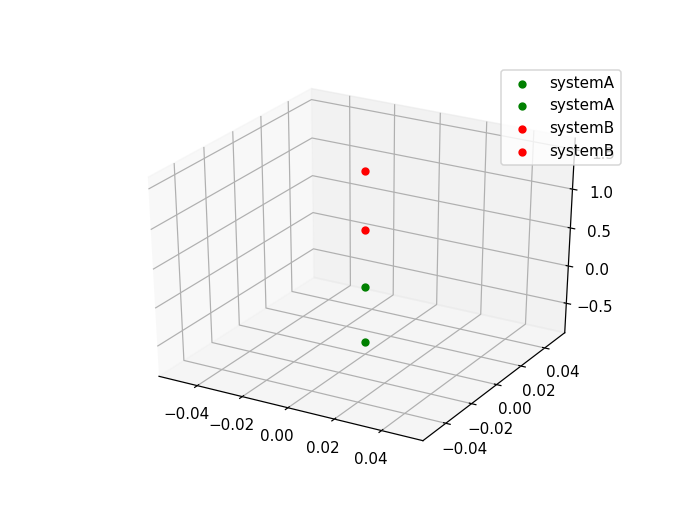

In [42]:
%matplotlib notebook

H_bond=0.74
R= 0.74 # distance of H2 --- R --- H2

Ha1=(0, 0, -H_bond)
Ha2= (0, 0, 0)

Hb1= (0,0,R)
Hb2= (0,0,R+H_bond)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*Ha1, marker='o', color='green', label='systemA')
ax.scatter(*Ha2, marker='o', color='green', label='systemA')
ax.scatter(*Hb1, marker='o', color='red', label='systemB')
ax.scatter(*Hb2, marker='o', color='red', label='systemB')
plt.legend()
plt.show()


### Define systems

In [43]:
mol_A = gto.Mole(atom='{} {} {} {}'.format('H',*Ha1) + "; " + '{} {} {} {}'.format('H',*Ha2),
               basis=basis_set,
               charge=0,
               spin=0)

print(mol_A.atom)
print('')
mol_A.build()

H 0 0 -0.74; H 0 0 0



In [44]:
mol_B = gto.Mole(atom='{} {} {} {}'.format('H',*Hb1) + "; " + '{} {} {} {}'.format('H',*Hb2),
               basis=basis_set,
               charge=0,
               spin=0)

print(mol_B.atom)
print('')
mol_B.build()

H 0 0 0.74; H 0 0 1.48



In [45]:
## define supersystem  --- QSOME
def __remove_overlap_ghost(mol):
    """Removes overlapping ghost atoms between mol objects
    Parameters
    __________
    mol : Mole object
        The mole object to remove ghost atoms from. Removes them in-place.
    Returns
    -------
    Mole object
        Mole object with overlapping ghost atoms removed
    """

    int_dist = gto.inter_distance(mol)
    same_coords = np.argwhere(int_dist == 0.0)
    remove_list = []
    while len(same_coords) > 0:
        curr_coord = same_coords[-1]
        if curr_coord[0] == curr_coord[1]:
            same_coords = same_coords[:-1]
        else:
            atom1 = mol.atom_symbol(curr_coord[0]).lower()
            atom2 = mol.atom_symbol(curr_coord[1]).lower()
            assert ("ghost" in atom1 or "ghost" in atom2),\
                    f"{atom1.capitalize()} and {atom2.capitalize()} are overlapping!"
            if "ghost" in atom2:
                remove_list.append(curr_coord[1])
            else:
                remove_list.append(curr_coord[0])
            same_coords = same_coords[:-1]
            inverse_coords = (curr_coord[1], curr_coord[0])
            inverse_index = np.argwhere((same_coords == inverse_coords).all(axis=1))
            same_coords = np.delete(same_coords, inverse_index, axis=0)

    for remove_index in sorted(remove_list, reverse=True):
        mol.atom.pop(remove_index)
    mol.build()
    return mol

def concat_mols(mol_list):
    """Concatenates Mole objects into one Mole.
    Parameters
    ----------
    mol_list : list
        List of Mole objects to concatenate into single Mole.
    """

    assert (len(mol_list) > 1), "Must have more than 1 mol object"

    total_spin = 0
    for i, mol_obj in enumerate(mol_list):
        mol1 = gto.mole.copy(mol_obj)
        total_spin += mol1.spin
        mol1.unit = 'bohr'
        atom_coords = mol1.atom_coords()
        mol1.atom = []
        uniq_atoms = set()
        for j, coord in enumerate(atom_coords):
            a_symb = mol1.atom_symbol(j) + '-' + str(i)
            uniq_atoms.add(a_symb)
            mol1.atom.append([a_symb, tuple(coord)])

        if isinstance(mol1.basis, (str, tuple, list)):
            new_basis = dict(((a, mol1.basis) for a in uniq_atoms))
        elif isinstance(mol1.basis, dict):
            old_basis = copy.copy(mol1.basis)
            new_basis = {}
            if 'default' in old_basis:
                default_basis = old_basis['default']
                new_basis = dict(((a, default_basis) for a in uniq_atoms))
                del old_basis['default']
            for atom_symb in old_basis:
                new_symb = atom_symb + '-' + str(i)
                new_basis[new_symb] = old_basis[atom_symb]
        else:
            new_basis = mol1.basis
        mol1.basis = gto.format_basis(new_basis)

        if mol1.ecp:
            if isinstance(mol1.ecp, str):
                new_ecp = dict(((a, str(mol1.ecp)) for a in uniq_atoms))
            elif isinstance(mol1.ecp, dict):
                old_ecp = copy.copy(mol1.ecp)
                if 'default' in old_ecp:
                    default_ecp = old_ecp['default']
                    new_ecp = dict(((a, default_ecp) for a in uniq_atoms))
                    del old_ecp['default']
                for atom_symb in old_ecp:
                    new_symb = atom_symb + '-' + str(i)
                    new_ecp[new_symb] = old_ecp[atom_symb]
            else:
                new_ecp = mol1.ecp
            mol1.ecp = gto.format_ecp(new_ecp)

        mol1.build()
        if i == 0:
            mol2 = gto.mole.copy(mol1)
        else:
            new_mol = gto.mole.conc_mol(mol1, mol2)
            new_mol.build()
            mol2 = new_mol

    conc_mol = mol2
    conc_mol.spin = total_spin #check that this works properly.
    #Remove overlapping ghost atoms.
    final_mol = __remove_overlap_ghost(conc_mol)
    return final_mol

new = concat_mols([mol_A, mol_B])
new.atom

[('H-1', [0.0, 0.0, 1.3983973321781458]),
 ('H-1', [0.0, 0.0, 2.7967946643562915]),
 ('H-0', [0.0, 0.0, -1.3983973321781458]),
 ('H-0', [0.0, 0.0, 0.0])]

In [46]:
## define supersystem  --- my_method 
    
new = mol_A + mol_B
new.atom

[('H', [0.0, 0.0, -1.3983973321781458]),
 ('H', [0.0, 0.0, 0.0]),
 ('H', [0.0, 0.0, 1.3983973321781458]),
 ('H', [0.0, 0.0, 2.7967946643562915])]

In [58]:
# Generate the translation matrix between subsystem to supersystem -- QSOME

def __gen_sub2sup(mol=None, subsystems=None):
        #There should be a better way to do this.
        """Generate the translation matrix between subsystem to supersystem.
        Parameters
        ----------
        mol : Mole
            Full system Mole object.
        subsystems : list
            List of subsystems which comprise the full system.
        """

#         if mol is None:
#             mol = self.mol
#         if subsystems is None:
#             subsystems = self.subsystems

        nao = np.array([sub.mol.nao_nr() for sub in subsystems])
        nssl = [None for i in range(len(subsystems))]

        for i, sub in enumerate(subsystems):
            nssl[i] = np.zeros(sub.mol.natm, dtype=int)
            for j in range(sub.mol.natm):
                ib_t = np.where(sub.mol._bas.transpose()[0] == j)[0]
                i_b = ib_t.min()
                ie_t = np.where(sub.mol._bas.transpose()[0] == j)[0]
                i_e = ie_t.max()
                i_r = sub.mol.nao_nr_range(i_b, i_e + 1)
                i_r = i_r[1] - i_r[0]
                nssl[i][j] = i_r

            assert nssl[i].sum() == sub.mol.nao_nr(), "naos not equal!"

        nsl = np.zeros(mol.natm, dtype=int)
        for i in range(mol.natm):
            i_b = np.where(mol._bas.transpose()[0] == i)[0].min()
            i_e = np.where(mol._bas.transpose()[0] == i)[0].max()
            i_r = mol.nao_nr_range(i_b, i_e + 1)
            i_r = i_r[1] - i_r[0]
            nsl[i] = i_r

        assert nsl.sum() == mol.nao_nr(), "naos not equal!"

        sub2sup = [None for i in range(len(subsystems))]
        for i, sub in enumerate(subsystems):
            sub2sup[i] = np.zeros(nao[i], dtype=int)
            for j in range(sub.mol.natm):
                match = False
                c_1 = sub.mol.atom_coord(j)
                for k in range(mol.natm):
                    c_2 = mol.atom_coord(k)
                    dist = np.dot(c_1 - c_2, c_1 - c_2)
                    if dist < 0.0001:
                        match = True
                        i_a = nssl[i][0:j].sum()
                        j_a = i_a + nssl[i][j]
                        #ja = ia + nsl[b]
                        i_b = nsl[0:k].sum()
                        j_b = i_b + nsl[k]
                        #jb = ib + nssl[i][a]
                        sub2sup[i][i_a:j_a] = range(i_b, j_b)

                assert match, 'no atom match!'
#         self.sub2sup = sub2sup
        return sub2sup #True

subsystems = [mol_A, mol_B]
super_mol = concat_mols(subsystems)
sub2sup = __gen_sub2sup(mol=super_mol, subsystems=subsystems)
sub2sup

converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF en

[array([2, 3]), array([0, 1])]

sub2sup basically gives the indices for each subsystem in the global object!

These are then accessed from the supersystem object using numpy.ix
- see [CLICK](https://stackoverflow.com/questions/62505046/what-does-numpy-ix-function-do-and-what-is-the-output-used-for)


It looks like pyscf just block encodes... but still worth checking!

Next the supersystem pyscf SCF object is intiilised, using supersystem_mol_obj!
- done in [method](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/cluster_supersystem.py#L399)
- gives:
    - full_system scf object (fs_scf)
    - not sure why  but QSOME also generates the u_scf_obj (unrestricted scf object too) which it labels os_scf

In [49]:
subsystems = [mol_A, mol_B]
super_mol = concat_mols(subsystems)

# code basically does:
fs_scf = scf.RKS(super_mol)

# note that the subsytem list is stored in the super_mol object of QSOME!

Next the supersystem parameters are found:
- the overlap matrix
- h_core
- mo_off

In [51]:
smat = fs_scf.get_ovlp()
hcore = fs_scf.get_hcore()

# Initialize everything!

Next the initial density guess for the supersystem density matrix is found (and each subsystem too, which is in the supermol object of QSOME!) [CLICK](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/cluster_supersystem.py#L496)

 - supersystem [calc](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/cluster_supersystem.py#L592)
     - note orbital localization is an option here!
     
- subsystem calc
    - uses ft_initguess (Inital density guess for freeze and thaw cycles._

In [64]:
# Pre calc!
subsystems = [mol_A, mol_B]
super_mol = concat_mols(subsystems)
fs_scf = scf.RKS(super_mol)
sub2sup = __gen_sub2sup(mol=super_mol, subsystems=subsystems)
smat = fs_scf.get_ovlp()


## supersystem
fs_scf.scf()
fs_dmat = fs_scf.make_rdm1()


# subsystem
for i, subsystem in enumerate(subsystems):
    sub_dmat = fs_dmat[np.ix_(sub2sup[i], sub2sup[i])]
#     sub_dmat = fs_dmat[1][np.ix_(sub2sup[i], sub2sup[i])] # for unrestricted case!

    temp_smat = smat[np.ix_(sub2sup[i], sub2sup[i])]
    
    #Normalize for num of electrons in each subsystem.(again can change for unrestricted alpha beta electron case!)
    num_e = np.trace(np.dot(sub_dmat, temp_smat))
    
    sub_dmat = sub_dmat*subsystem.mol.nelec[0]/num_e
    
    Initialize

converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF energy = -1.11675930739642
converged SCF en

(note still on initializing everything [CLICK](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/cluster_supersystem.py#L496))

next:
- update **full** system fock matrix [CLICK](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/cluster_supersystem.py#L870)
- and then update projection operator!

In [84]:
# full system Fock matrix and sub system fock matrices!
### this is self.update_fock() function!!!!

# # Pre calc!
# subsystems = [mol_A, mol_B]
# super_mol = concat_mols(subsystems)
# fs_scf = scf.RKS(super_mol)
# sub2sup = __gen_sub2sup(mol=super_mol, subsystems=subsystems)
# smat = fs_scf.get_ovlp()
# ft_diis = lib.diis.DIIS()
# ##

num_rank = super_mol.nao_nr()
dmat = np.zeros((num_rank, num_rank))#, np.zeros((num_rank, num_rank))] # exludes beta e- part!
# ^^^ note dmat here is emtpy!

# aka generate density matrix of full system from subsystems!
for i, subsystem in enumerate(subsystems):
    dmat[np.ix_(sub2sup[i], sub2sup[i])] += subsystem.env_dmat # calculated before!
    
emb_vhf = fs_scf.get_veff(super_mol, dmat)
temp_fock = fs_scf.get_fock(h1e=fs_scf.get_hcore(), vhf=emb_vhf, dm=dmat)

new_fock = ft_diis.update(temp_fock)

#     self.fock = new_fock # <-usual code
# Full_System_Fock = new_fock # <-my version
fs_scf.Full_System_Fock = new_fock # < set python obj attribute!
    
    

# Next get subsystem embedded Fock matrices for each subsystem
for i, subsystem in enumerate(subsystems):
#     subsystem_embedded_Fock = Full_System_Fock[np.ix_(sub2sup[i], sub2sup[i])]
    subsystem.emb_fock = fs_scf.Full_System_Fock[np.ix_(sub2sup[i], sub2sup[i])] # < set python obj attribute!

In [90]:
# update projection op
### this is self.update_proj_pot() function!!!!

# # Pre calc!
# subsystems = [mol_A, mol_B]
# super_mol = concat_mols(subsystems)
# fs_scf = scf.RKS(super_mol)
# sub2sup = __gen_sub2sup(mol=super_mol, subsystems=subsystems)
# smat = fs_scf.get_ovlp()
# ft_diis = lib.diis.DIIS()
proj_pot_LIST = [np.array([0.0]) for sub in subsystems]
# ##
Full_System_Fock= None


project_op_dict={}
# aka generate density matrix of full system from subsystems!
for i, subsystem in enumerate(subsystems):
    num_rank = subsystem.nao_nr()
    proj_op = np.zeros((num_rank, num_rank))# exludes beta e- part!

    # cycle over all other subsystems
    for j, sub_b in enumerate(subsystems):
        
        if j == i:
            continue
        sub_b_dmat = sub_b.env_dmat
        smat_ab = smat[np.ix_(sub2sup[i], sub2sup[j])] # note i and j
        smat_ba = smat[np.ix_(sub2sup[j], sub2sup[i])]
        
        # huzinaga operator!
        fock_ab = fs_scf.Full_System_Fock[np.ix_(sub2sup[i], sub2sup[j])] # note i and j
        fock_den_smat = np.dot(fock_ab, np.dot(sub_b_dmat, smat_ba))
        
        proj_op+= -1. * (fock_den_smat + fock_den_smat.transpose())
        
    proj_pot_LIST[i] = proj_op.copy()

# Initialize END

# NOW do embedding!
- ```do_embedding``` [**method**](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/interaction_mediator.py#L172)
    - This does freeze and thaw on supersystem (code loops over supersystems... we only have 1 !!)
    
- aka only runs ```freeze_and_thaw``` on the supersystem!
    - [freeze_and_thaw](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/cluster_supersystem.py#L1199)
    - which does subsystem density optimization

In [92]:
## freeze and thaw over subsystems!
## QSOME method acts on supersystem cluster object
# this is PSEUDO CODE (will not run)

## I will represent this as FULL_SYS_OBJ
#### this has the properites:
######## global fock matrix... which we calculated manually above as fs_scf.Full_System_Fock
######## proj_pot_LIST (calculated above too!) 
######## contains list of subsystems!
################ each subsystem has properties
######################## embedded Fock matrix ==> which we calculated manually above as subsystem.emb_fock

#while((ft_err > self.ft_conv) and (ft_iter < self.ft_cycles)):
# normally convergence criteria
for _ in range(max_iter):
    FULL_SYS_OBJ.update_fock() # updates global fock matrix! abd calculates subsystem emb_fock (stored as attribute of each subsystem!)
    
    FULL_SYS_OBJ.update_proj_pot() # gets Huzinga operator for each subsystem
    # this is stored in object of cluster system... above we calcualted it as: proj_pot_LIST
    
    
    #next iterate over subsystems
    for i, subsystem in enumerate(FULL_SYS_OBJ.subsystems):
        
        subsystem.proj_pot = FULL_SYS_OBJ.proj_pot_LIST[i]
        # note above is subsystem property (attribute USED for diagonalization next!)
        
        ###### diagonalise
        sub_old_dm = subsystem.get_dmat()
        
        dmat = subsystem.env_dmat
        hcore = subsystem.env_hcore
        subsys_fock = self.env_scf.get_fock(h1e=hcore, dm=dmat)
        
        subsystem.env_dmat = np.dot((subsystem.env_mo_coeff[0] * subsystem.env_mo_occ[0]),
                                      subsystem.env_mo_coeff[0].transpose().conjugate())
        
        # convergence!!
        ddm = sp.linalg.norm(subsystem.env_dmat - sub_old_dm) # new - old
        # this gets adds to an error that resets when it hits outside while loop
        # check original code! I haven't included convergence criteria here
        
        ###### END diagonalise
        
        # Gets the projection operator energy
        e_proj = np.einsum('ij,ji', subsystem.proj_pot, subsystem.env_dmat)

        
        
# print subsystem energies
for i in range(len(self.subsystems)):
    subsystem = self.subsystems[i]
    subsystem.get_env_energy()
    print(f"Subsystem {i} Energy:{subsystem.env_energy:>61.8f}")

# Next get full embedded energy

performed in object: [InteractionMediator](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/interaction_mediator.py#L172)

via calling the [**method**](https://github.com/Goodpaster/QSoME/blob/f8081f58cb6531ac26091cc12a4161620618b057/qsome/interaction_mediator.py#L191) : ```get_emb_energy``` 

In [ ]:
sup = self.supersystems[-1]
sup_e = sup.get_supersystem_energy()
sup.get_env_in_env_energy()
sup.get_hl_energy()
sup.get_env_energy()
energy_tot += sup_e
for sub in sup.subsystems:
    #THIS IS VERY HACKY. NEED TO COME UP WITH A BETTER WAY TO GET SUBSYSTEM STUFF.
    if 'hl_energy' in vars(sub):
        energy_tot -= sub.env_energy
        energy_tot += sub.hl_energy

print("".center(80, '*'))
print(f"Total Embedding Energy:     {energy_tot}")
print("".center(80, '*'))
return energy_tot